# Unsupervised learning methods for rapid data analysis @ NSLS-II

<img src="resources/nsls2.PNG" alt="NSLS2" style="width: 450px; height: 250px;"/>

### Dan Olds, Hard X-ray Scattering and Spectroscopy, PDF, NSLS-II 
### NSLS-II and CFN Users' Meeting 2022

Facilitated by advances in source brightnesses and detector technology, we have seen an expansive growth of in situ and high-throughput studies x-ray light sources. Consequentially, the data generation rates have also skyrocketed, with over a PB of raw data generated last year at NSLS-II.  Despite these advances in measurement capabilities, many of our approaches to analysis have not kept up.  Consequentially, data measured in seconds to minutes may take days-to-weeks in order to fully comprehend. This limits the capabalities of users at the beamlines to fully understand the nature of their experement while it is undertaken - leading to the potential for mistakes, missed oppertunities, and under-utilization of limited beamtime.

While the term 'machine learning' often springs to mind big-data consuming supervised learning approaches driven by neural networks, unsupervised learning methods are a highly effective set of tools for delivering rapid insights to large datasets. This is because unsupervised learning algorithms identify and react to commonalities in data without requiring prior knowledge of the class, category, or label for each datum. Thus, these unsupervised methods offer an attractive capability to rapidly understand streams of big data from the beamlines, offering users immidiate insights during the measurement.

In [1]:
from tiled.client import from_uri, from_profile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load the data

We will first load the temperature dependent BaTiO3 dataset, measured at the PDF beamline at NSLS-II, using Tiled.

In [2]:
c = from_uri("https://tiled-demo.blueskyproject.io/api")

In [3]:
data = c['um2022']['olds']['BaTiO3_VT']

We happen to know the temperature setpoints used during the measurement (100-500 K). We can create a Pandas dataframe where the data column labels correspond to these setpoints.

In [4]:
data = c['um2022']['olds']['BaTiO3_VT']

file_list = sorted(list(data))

temp_df_list = []
for i in range(len(file_list)):
    temp_df_list.append(data[file_list[i]].read())

bto_data = pd.concat(temp_df_list,axis=1)

T_setpoints = np.arange(100,502,2,dtype=float)

bto_data.columns = T_setpoints

From literature, we also know where to expect the phase transition temperatures of BaTiO3.  We will use this information to check how the various algorithms perform.

In [5]:
expected_Ttransitions = [196, 285, 401]


### Look at data

Users are always, always, ALWAYS encouraged to look at their data prior to performing analysis.

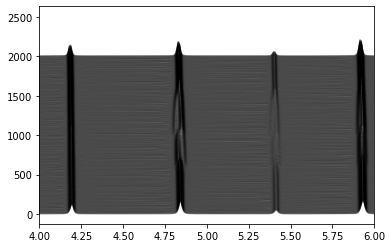

In [6]:
plt.figure()
for i in range(len(bto_data.columns)):
    plt.plot(bto_data.iloc[:,i]+10*i,color='k',alpha=.5);
plt.xlim(4,6);

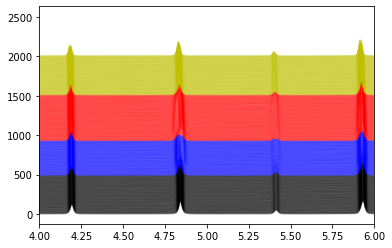

In [7]:
plt.figure()
clist = ['k','b','r','y']

for i in range(len(bto_data.columns)):
    
    this_t = bto_data.columns[i]
    
    use_c = 0
    if this_t > expected_Ttransitions[0]:
        use_c += 1
    if this_t > expected_Ttransitions[1]:
        use_c += 1
    if this_t > expected_Ttransitions[2]:
        use_c += 1
        
        
    plt.plot(bto_data.iloc[:,i]+10*i,color=clist[use_c],alpha=.5);
plt.xlim(4,6);

In [8]:
def make_colormap(num_ids,use_cmap='viridis'):
    num_colors = (num_ids)
    cm = plt.cm.get_cmap(name=use_cmap)
    currentColors = [cm(1.*i/num_colors) for i in range(num_colors)]
    return currentColors

Let's make a waterfall plot of one particular reflection, where we know we can see dramatic changes occuring.

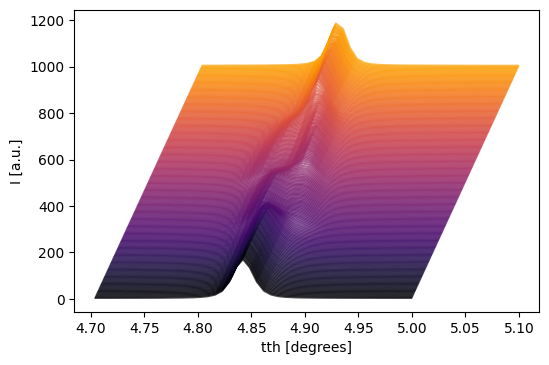

In [9]:
plt.figure(dpi=100)
cc = make_colormap(len(bto_data.columns)+50, use_cmap='inferno')

tth = bto_data.loc[4.7:5].index

for i in range(len(bto_data.columns)):
    this_t = bto_data.columns[i]
    plt.plot(tth+i*.0005,bto_data.loc[4.7:5,this_t]+i*5,c=cc[i],alpha=.7)
    
plt.xlabel('tth [degrees]');
plt.ylabel('I [a.u.]');

### Heirarchical Clustering

Clustering methods are concerned with dividing data intorelated groups that have similar properties or features. These include algorithms such as expectation maximization, k-means clustering, and hierarchical clustering. Commonly used during exploratory data analysis or to produce preliminary groupings, these methods are difficult to evaluate in their true unlabeled setting and are often ranked using a similar labeled dataset. The choice of model is often dependent on the shape of the data distribution. 

We here demonstrate the heirarchical clustering method availble as part of scikit-learn.

In [10]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete, single, fcluster
from scipy.spatial.distance import pdist

We will look at cases of using both the full dataset, and a limited region of interest defined by the peak near 4.8 degrees.

Dendrograms offer a fast, concise method of understanding how the data is being clustered. Scikit-learn offers several excellent options - the full scope and understanding of which is left as an excercise for the reader.

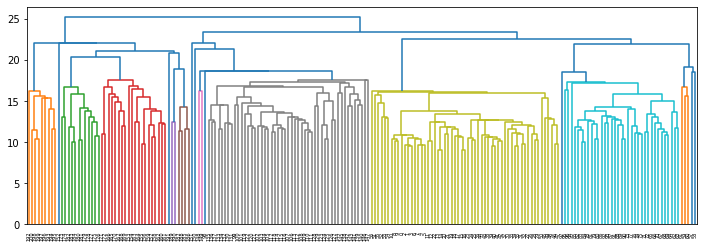

In [11]:
plt.figure(figsize = (12,4))
sch.dendrogram(sch.linkage(bto_data.loc[1:15,:].T, method = "single"));

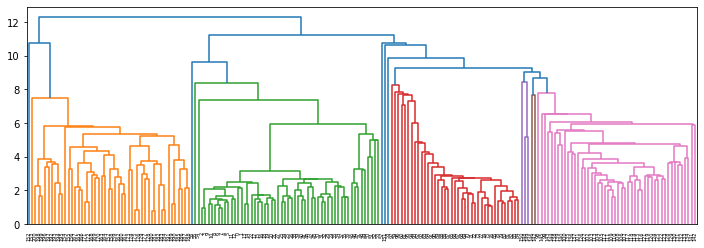

In [12]:
plt.figure(figsize = (12,4))
sch.dendrogram(sch.linkage(bto_data.loc[4.7:5,:].T, method = "single"));

Generating the clusters via Wark linkages

In [13]:
# Calculate pairwise distances 
y = pdist(bto_data.loc[4.7:5,:].T)
y_all = pdist(bto_data.loc[1:15,:].T)

# Calculate Ward linkage on those distances
Z = ward(y)
Z_all = ward(y_all)

# Generate cluster labels from the hierarchical clustering defined given linkage matrix - you may have to adjust cutoff
wardlabel = fcluster(Z, 500, criterion='distance') 
wardlabel_all = fcluster(Z_all, 900, criterion='distance')

print(max(wardlabel))
print (max(wardlabel_all))

4
4


Looking at the clusters with respect to the temperature series.

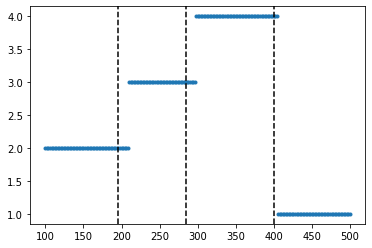

In [14]:
plt.figure()
plt.plot(T_setpoints,wardlabel_all,'.')
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
   

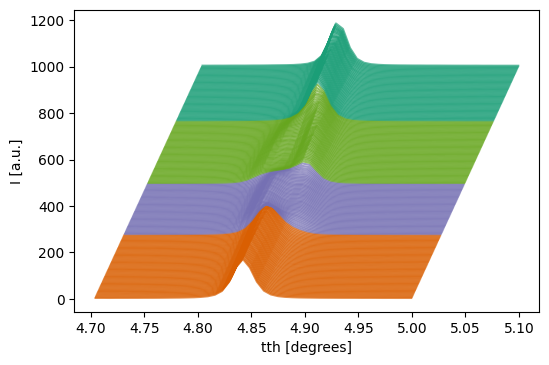

In [15]:
plt.figure(dpi=100)
cc = make_colormap(6, use_cmap='Dark2')

tth = bto_data.loc[4.7:5].index

for i in range(len(bto_data.columns)):
    this_t = bto_data.columns[i]
    plt.plot(tth+i*.0005,bto_data.loc[4.7:5,this_t]+i*5,c=cc[wardlabel_all[i]-1],alpha=.7)
    
plt.xlabel('tth [degrees]');
plt.ylabel('I [a.u.]');

### Principle Component Analysis (PCA)

Dimensionality reduction methods attempt to reduce or project data into a lower dimensional subspace that captures the core or distinguishing information content of the data. One of the most common methods is called Principle Component Analysis (PCA). Similar to Eigenvector / Eigenvalues, PCA can be thought of decomposing data into individual constintuent parts or components and a set of corresponding weights.  For each datum, there will be one weight per component.  If succesful, the full dataset is reconstructed by multiplying the weights with the corresponding components.

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=4)

pca.fit(bto_data.loc[4.7:5,:])
this_tth = np.array(bto_data.loc[4.7:5].index)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


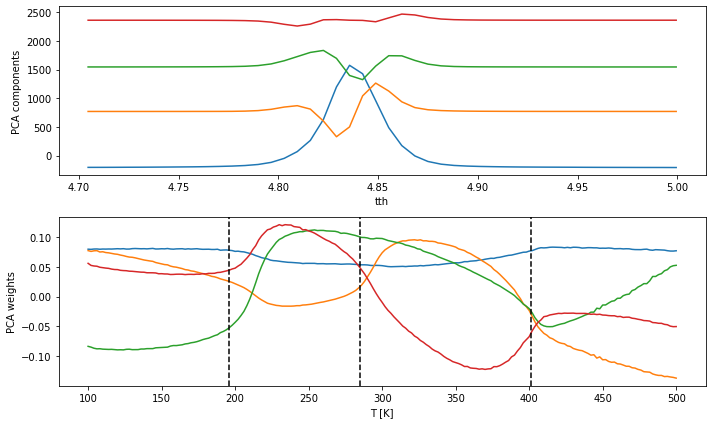

In [18]:
plt.figure(figsize=(10,6))

pca_weights = pca.components_.T
pca_comps = pca.fit_transform(bto_data.loc[4.7:5,:])

plt.subplot(211)
for i in range(len(pca_comps.T)):
    plt.plot(this_tth,pca_comps.T[i]+i*(pca_comps.max())*.5);
plt.ylabel('PCA components');
plt.xlabel('tth');
plt.subplot(212)
plt.plot(T_setpoints, pca_weights);
plt.ylabel('PCA weights');
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
plt.xlabel('T [K]');

plt.tight_layout()


Note that as the reconstruction is a product of the weights and the components, multiplying the components and weights by inversely proportional scaling factors has no effect on the overall fit quality. Thus, we may rescale the data if we wanted to say - limit the weights to a maxima of one (a constraint not inherent to PCA as a whole).

Notice also that weights and components in PCA can be negative, implying that features can be both added and removed from PCA reconstructions. This can result in non-physical weighting schemas, as features added by one component can be removed by another. 

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


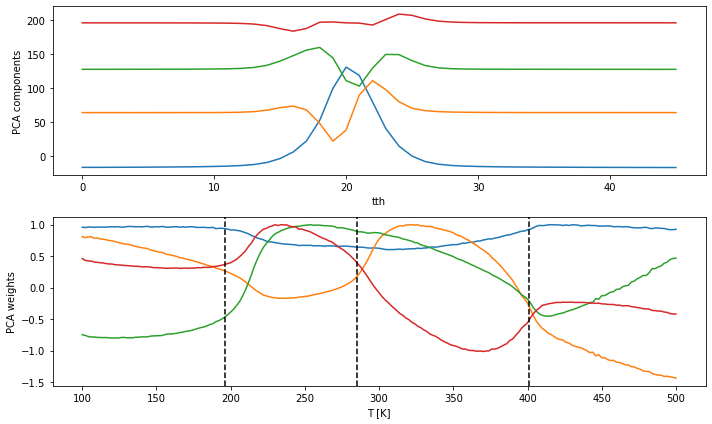

In [19]:
plt.figure(figsize=(10,6))

pca_weights = pca.components_.T
pca_comps = pca.fit_transform(bto_data.loc[4.7:5,:])

rescale = pca_weights.max(axis=0)
pca_weights /= rescale
pca_comps*=rescale

plt.subplot(211)
for i in range(len(pca_comps.T)):
    plt.plot(pca_comps.T[i]+i*(pca_comps.max())*.5);
plt.ylabel('PCA components');
plt.xlabel('tth');
plt.subplot(212)
plt.plot(T_setpoints, pca_weights);
plt.ylabel('PCA weights');
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
plt.xlabel('T [K]');

plt.tight_layout()

### Non-negative Matrix Factorization (NMF)

NMF is a dimensionality reduction algorithm similar to PCA with an added constraint that all component signal must be greater than or equal to zero, and are strictly additive. The behavior mirrors that encountered in many physical systems, such as in x-ray scattering, where linear combinations of different material components will also produce an additive combined signal.  

Although none of these dimensionality redution algorithms is assured to produce a unique solution, the addition of the constraints found in NMF often drives the as-fit components and weights to be more representative of the underlying physical system.

In [20]:
from sklearn.decomposition import NMF


In [21]:
model = NMF(n_components=4, init='nndsvda', random_state=0,max_iter=1000)
W = model.fit_transform(bto_data.loc[4.7:5,:].T)
H = model.components_

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


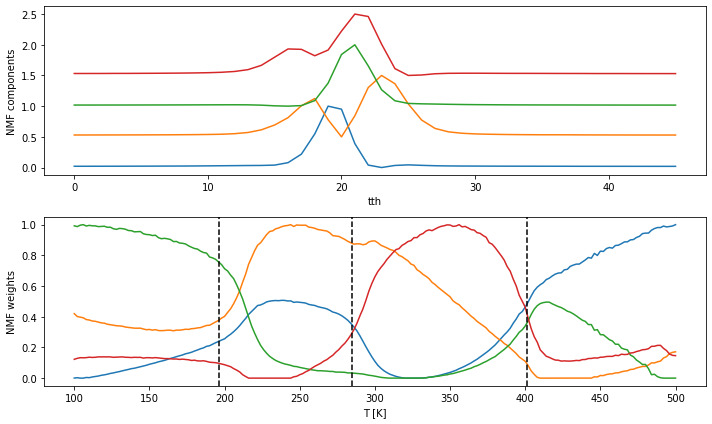

In [22]:
plt.figure(figsize=(10,6))
plt.subplot(211)
for i in range(len(H)):
    plt.plot(H[i].T/np.max(H[i].T,axis=0)+i*.5);

plt.ylabel('NMF components');
plt.xlabel('tth');
           
plt.subplot(212)
plt.plot(T_setpoints,W/np.max(W,axis=0));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')

plt.ylabel('NMF weights');
plt.xlabel('T [K]');

plt.tight_layout()

### Constrained Matrix Factorization
As demonstrated by NMF, the addition of constraints in our dimensionality reduction of spectral datasets from NSLS-II often results in more physically meaningful, and readily interpretable results.  But can we add further constraints beyond non-negativity?

Often, researchers come to a beamline experement with some prior knowledge of their material system under study. For example, they may know the a subset of the expected phases present in the sample.  If nothing else, we may take in initial measurement of the material prior to performing any in situ studies (such as changing temperatures). That ambient measurement data often represents a single phase of the material, and thus, something we might hope to find in our fit components.

We have recently developed a method of applying additional constraints to NMF (https://doi.org/10.1063/5.0052859), which has an open-source pyTorch implementation availble.  We will employ it here using the so-called 'auto-constraints', where components are selected by the algorithm based on simple assumptions.

In [23]:
from cmf_utils import AutoNMFCompanion


In [24]:
companion = AutoNMFCompanion(4,
                             q=bto_data.loc[4.7:5,:].index.to_numpy(),
                             normalize=True
                             )


In [25]:
companion.tell_many(T_setpoints[:, None], bto_data.loc[4.7:5,:].to_numpy().T)
companion.report()

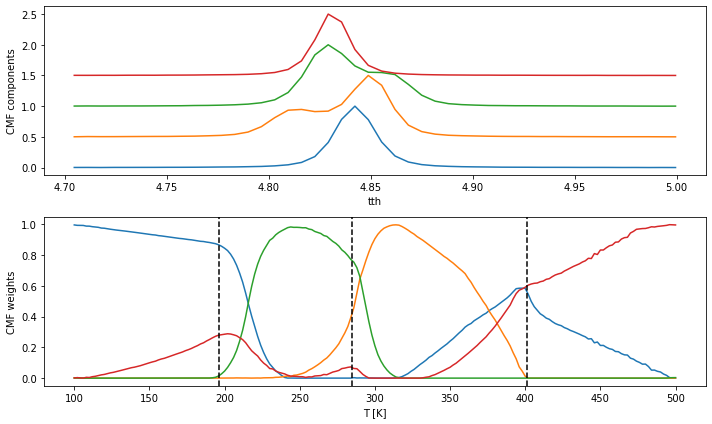

In [26]:
plt.figure(figsize=(10,6))
plt.subplot(211)
for i in range(len(companion.dependent_components)):
    plt.plot(this_tth, companion.dependent_components[i]+i*.5);
plt.ylabel('CMF components');
plt.xlabel('tth');
           

plt.subplot(212)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, companion.dependent_weights.T[i]);
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
plt.ylabel('CMF weights');
plt.xlabel('T [K]')

plt.tight_layout()

## Comparison of PCA, NMF, and CMF

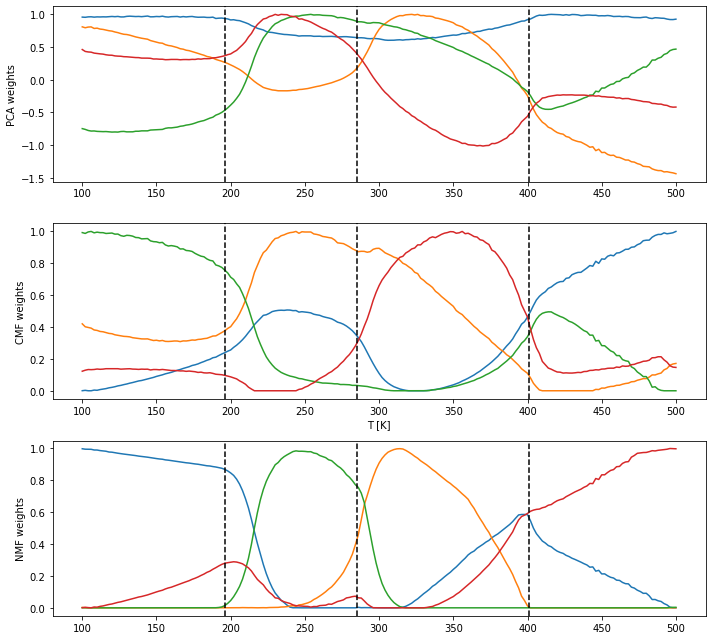

In [27]:
plt.figure(figsize=(10,9))

plt.subplot(311)
plt.plot(T_setpoints, pca_weights);

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
plt.ylabel('PCA weights');
    
plt.subplot(313)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, companion.dependent_weights.T[i]);
    
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
plt.ylabel('NMF weights');

plt.subplot(312)
plt.plot(T_setpoints,W/np.max(W,axis=0));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')

plt.ylabel('CMF weights');
plt.xlabel('T [K]');
plt.tight_layout()

### Gradient Comparison

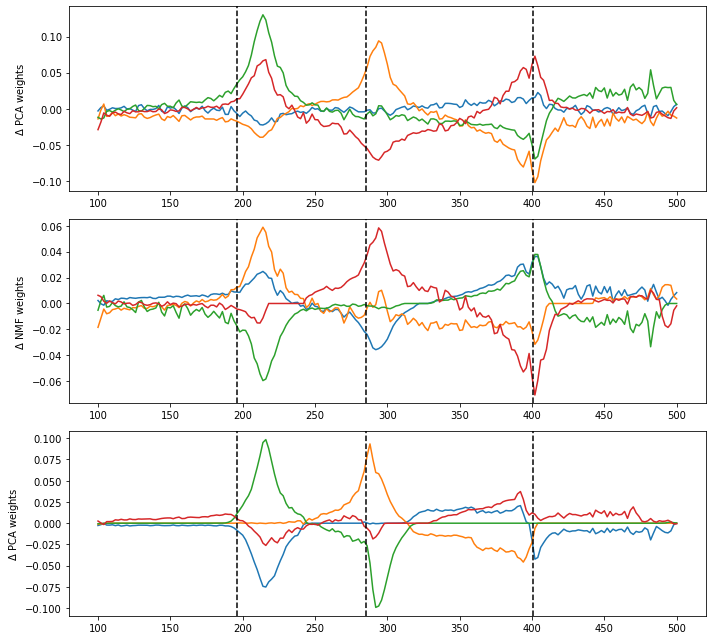

In [28]:
plt.figure(figsize=(10,9))

plt.subplot(311)

for i in range(4):
    plt.plot(T_setpoints, np.gradient(pca_weights.T[i]));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
plt.ylabel('$\Delta$ PCA weights');
###################

plt.subplot(312)
for i in range(4):
    plt.plot(T_setpoints,np.gradient(W.T[i]/np.max(W.T[i],axis=0)));

for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
plt.ylabel('$\Delta$ NMF weights');

###############
    
plt.subplot(313)
for i in range(len(companion.dependent_weights.T)):
    plt.plot(T_setpoints, np.gradient(companion.dependent_weights.T[i]));
plt.ylabel('$\Delta$ PCA weights');
   
    
for t in expected_Ttransitions:
    plt.axvline(t,c='k',ls='--')
   
plt.tight_layout()